In [1]:
import torch
from diffusers import DDPMScheduler, UNet1DModel
from fco2models.models import UNet2DModelWrapper
import json
import numpy as np

def load_model(save_dir, model_path, model_class):
    #read model hyperparameters
    with open(save_dir+'hyperparameters.json', 'r') as f:
        params = json.load(f)

    with open(save_dir+'losses.json', 'r') as f:
        losses = json.load(f)
    
    model_params = params['model_params']
    noise_params = params['noise_params']

    # load the model
    model = model_class(**model_params)
    model.load_state_dict(torch.load(save_dir+model_path))
    model.eval()
    noise_scheduler = DDPMScheduler(**noise_params)

    return model, noise_scheduler, params, losses

# read validation data from npy file
val_ds = np.load('../models/renko/seasonal/val_ds.npy')
print(val_ds.shape)
# load the models
# unet2d with two convolutional blocks, 2 layers each, plus day_of_year as input (100 epochs)
seas_noattn_100, ns1, pars1, ls1 = load_model('../models/renko/seasonal/noattn/', 'e_100.pt', UNet2DModelWrapper)
# unet2d with two convolutional blocks, 2 layers each (100 epochs)
noattn_100, ns2, pars2, ls2 = load_model('../models/renko/unet2d_noattn/', 'e_100.pt', UNet2DModelWrapper)
# longest trained unet2d with one an convolutional block and one attention block, 2 layers each (220 epochs)
conv_attn_220, ns3, pars3, ls3 = load_model('../models/renko/unet2d_fixsplit/', 'e_220.pt', UNet2DModelWrapper)
# model with attention layer first and then a convolutional block, 2 layers each (50 epochs)
attn_first_50, ns4, pars4, ls4 = load_model('../models/renko/attn_first/', 'e_50.pt', UNet2DModelWrapper)
conv_attn_300, ns3, pars3, ls3 = load_model('../models/renko/unet2d_fixsplit/', 'e_300.pt', UNet2DModelWrapper)

models = dict({})
# uncond_unet1d, noise_scheduler = load_model('../models/unconditional_128_0.001/', 'e_50.pt', UNet1DModel)
models['seas_noattn_100'] = dict({'model': seas_noattn_100, 'scheduler': ns1, 'params': pars1, 'losses': ls1})
models['noattn_100'] = dict({'model': noattn_100, 'scheduler': ns2, 'params': pars2, 'losses': ls2})
models['conv_attn_220'] = dict({'model': conv_attn_220, 'scheduler': ns3, 'params': pars3, 'losses': ls3})
models['attn_first_50'] = dict({'model': attn_first_50, 'scheduler': ns4, 'params': pars4, 'losses': ls4})
models['conv_attn_300'] = dict({'model': conv_attn_300, 'scheduler': ns3, 'params': pars3, 'losses': ls3})



(33768, 5, 64)


In [2]:
# compute these values for all models
for key in models.keys():
    train_losses = np.array(models[key]['losses']['train_losses'])
    val_losses = np.array(models[key]['losses']['val_losses'])
    print(f'loading {key}')

    min_epoch = np.argmin(train_losses)
    print('min epoch:', min_epoch)
    print('min train loss:', train_losses[min_epoch])

    min_los_avg = np.mean(val_losses, axis=1)
    min_epoch_val = np.argmin(min_los_avg)
    print('min val loss epoch:', min_epoch_val)
    print('min val loss:', min_los_avg[min_epoch_val])
    print('----------------------------------')


loading seas_noattn_100
min epoch: 99
min train loss: 0.024421204629520406
min val loss epoch: 98
min val loss: 0.07840087386711359
----------------------------------
loading noattn_100
min epoch: 99
min train loss: 0.024658476514286366
min val loss epoch: 98
min val loss: 0.0780834779717569
----------------------------------
loading conv_attn_220
min epoch: 284
min train loss: 0.022061293307136208
min val loss epoch: 117
min val loss: 0.07866493882650255
----------------------------------
loading attn_first_50
min epoch: 48
min train loss: 0.025278239247951573
min val loss epoch: 47
min val loss: 0.07776991248699067
----------------------------------
loading conv_attn_300
min epoch: 284
min train loss: 0.022061293307136208
min val loss epoch: 117
min val loss: 0.07866493882650255
----------------------------------


# Denoise sample from given noise level

In [ ]:
def rec_sample(sample_context, model, noise_scheduler, timesteps):
    sample = torch.from_numpy(sample_context[0:1, :]).float()
    context = torch.from_numpy(sample_context[1:, :]).float()
    # add nan mask to the context
    nan_mask = ~torch.isnan(sample)
    context = torch.cat([context, nan_mask.float()], dim=0)

    nan_sample = torch.where(nan_mask, sample, torch.zeros_like(sample))
    # sample 100 times and plot the distribution of reconstructed fco2
    reconstructed_fco2s = []
    noisy_samples = []
    model.to('cpu')
    for _ in range(100):
        noise = torch.randn_like(nan_sample)
        noisy_sample = noise_scheduler.add_noise(nan_sample, noise, timesteps)
        input = torch.cat([noisy_sample, context], dim=0).unsqueeze(0)
        with torch.no_grad():
            output = model(input, timesteps)
    
        nan_fco2 = noise_scheduler.step(output[0], timesteps.item(), noisy_sample).pred_original_sample
        rec_fco2 = torch.where(nan_mask, nan_fco2, np.nan) # put in nans for better plotting
        reconstructed_fco2s.append(rec_fco2.numpy().flatten())
        # save noisy sample for plotting
        nan_noisy_sample = torch.where(nan_mask, noisy_sample, np.nan)
        noisy_samples.append(nan_noisy_sample.numpy().flatten())
    
    reconstructed_fco2s = np.array(reconstructed_fco2s)
    noisy_samples = np.array(noisy_samples)

    return reconstructed_fco2s, noisy_samples

def plot_rec(ax, recfco2s, noisy_samples, truth, title, plot_noisy=True):
    # print('recfco2s shape:', recfco2s.shape)
    line01 = ax.plot(recfco2s.T[:,:10], color='blue', alpha=0.5)
    # plot devations from the mean
    # print('recfco2s std:', recfco2s.std(axis=0))
    ax.fill_between(np.arange(0, 64), recfco2s.mean(axis=0) - recfco2s.std(axis=0),
                     recfco2s.mean(axis=0) + recfco2s.std(axis=0), color='blue', alpha=0.5)
    if plot_noisy:
        # plot noisy samples
        line02 = ax.plot(noisy_samples.T[:,:10], color='green', alpha=0.5)
    ax.plot(recfco2s.mean(axis=0), label='reconstructed fco2', color='blue')
    ax.plot(truth.flatten(), 'o-', label='true fco2', color='red')
    if plot_noisy:
        ax.legend(handles=[line01[0], line02[0]], labels=['reconstructed fco2', 'noisy sample'])
    else:
        ax.legend(handles=[line01[0]], labels=['reconstructed fco2'])
    ax.set_title(title)
    ax.set_xlabel('distance')
    ax.set_ylabel('fco2')
    return ax


In [4]:
# sort samples by largest std
# ix = np.argsort(np.nanstd(val_ds[:, 0, :], axis=1))[::-1][100]
ix = 157
sample = val_ds[ix]
for model_name, model_dict in models.items():
    if model_name == 'seas_noattn_100':
        model_dict['sample'] = sample
    else:
        model_dict['sample'] = sample[:4, :]

157
mean and std of the sample fco2: 0.249699247284147, 0.14258934597580022


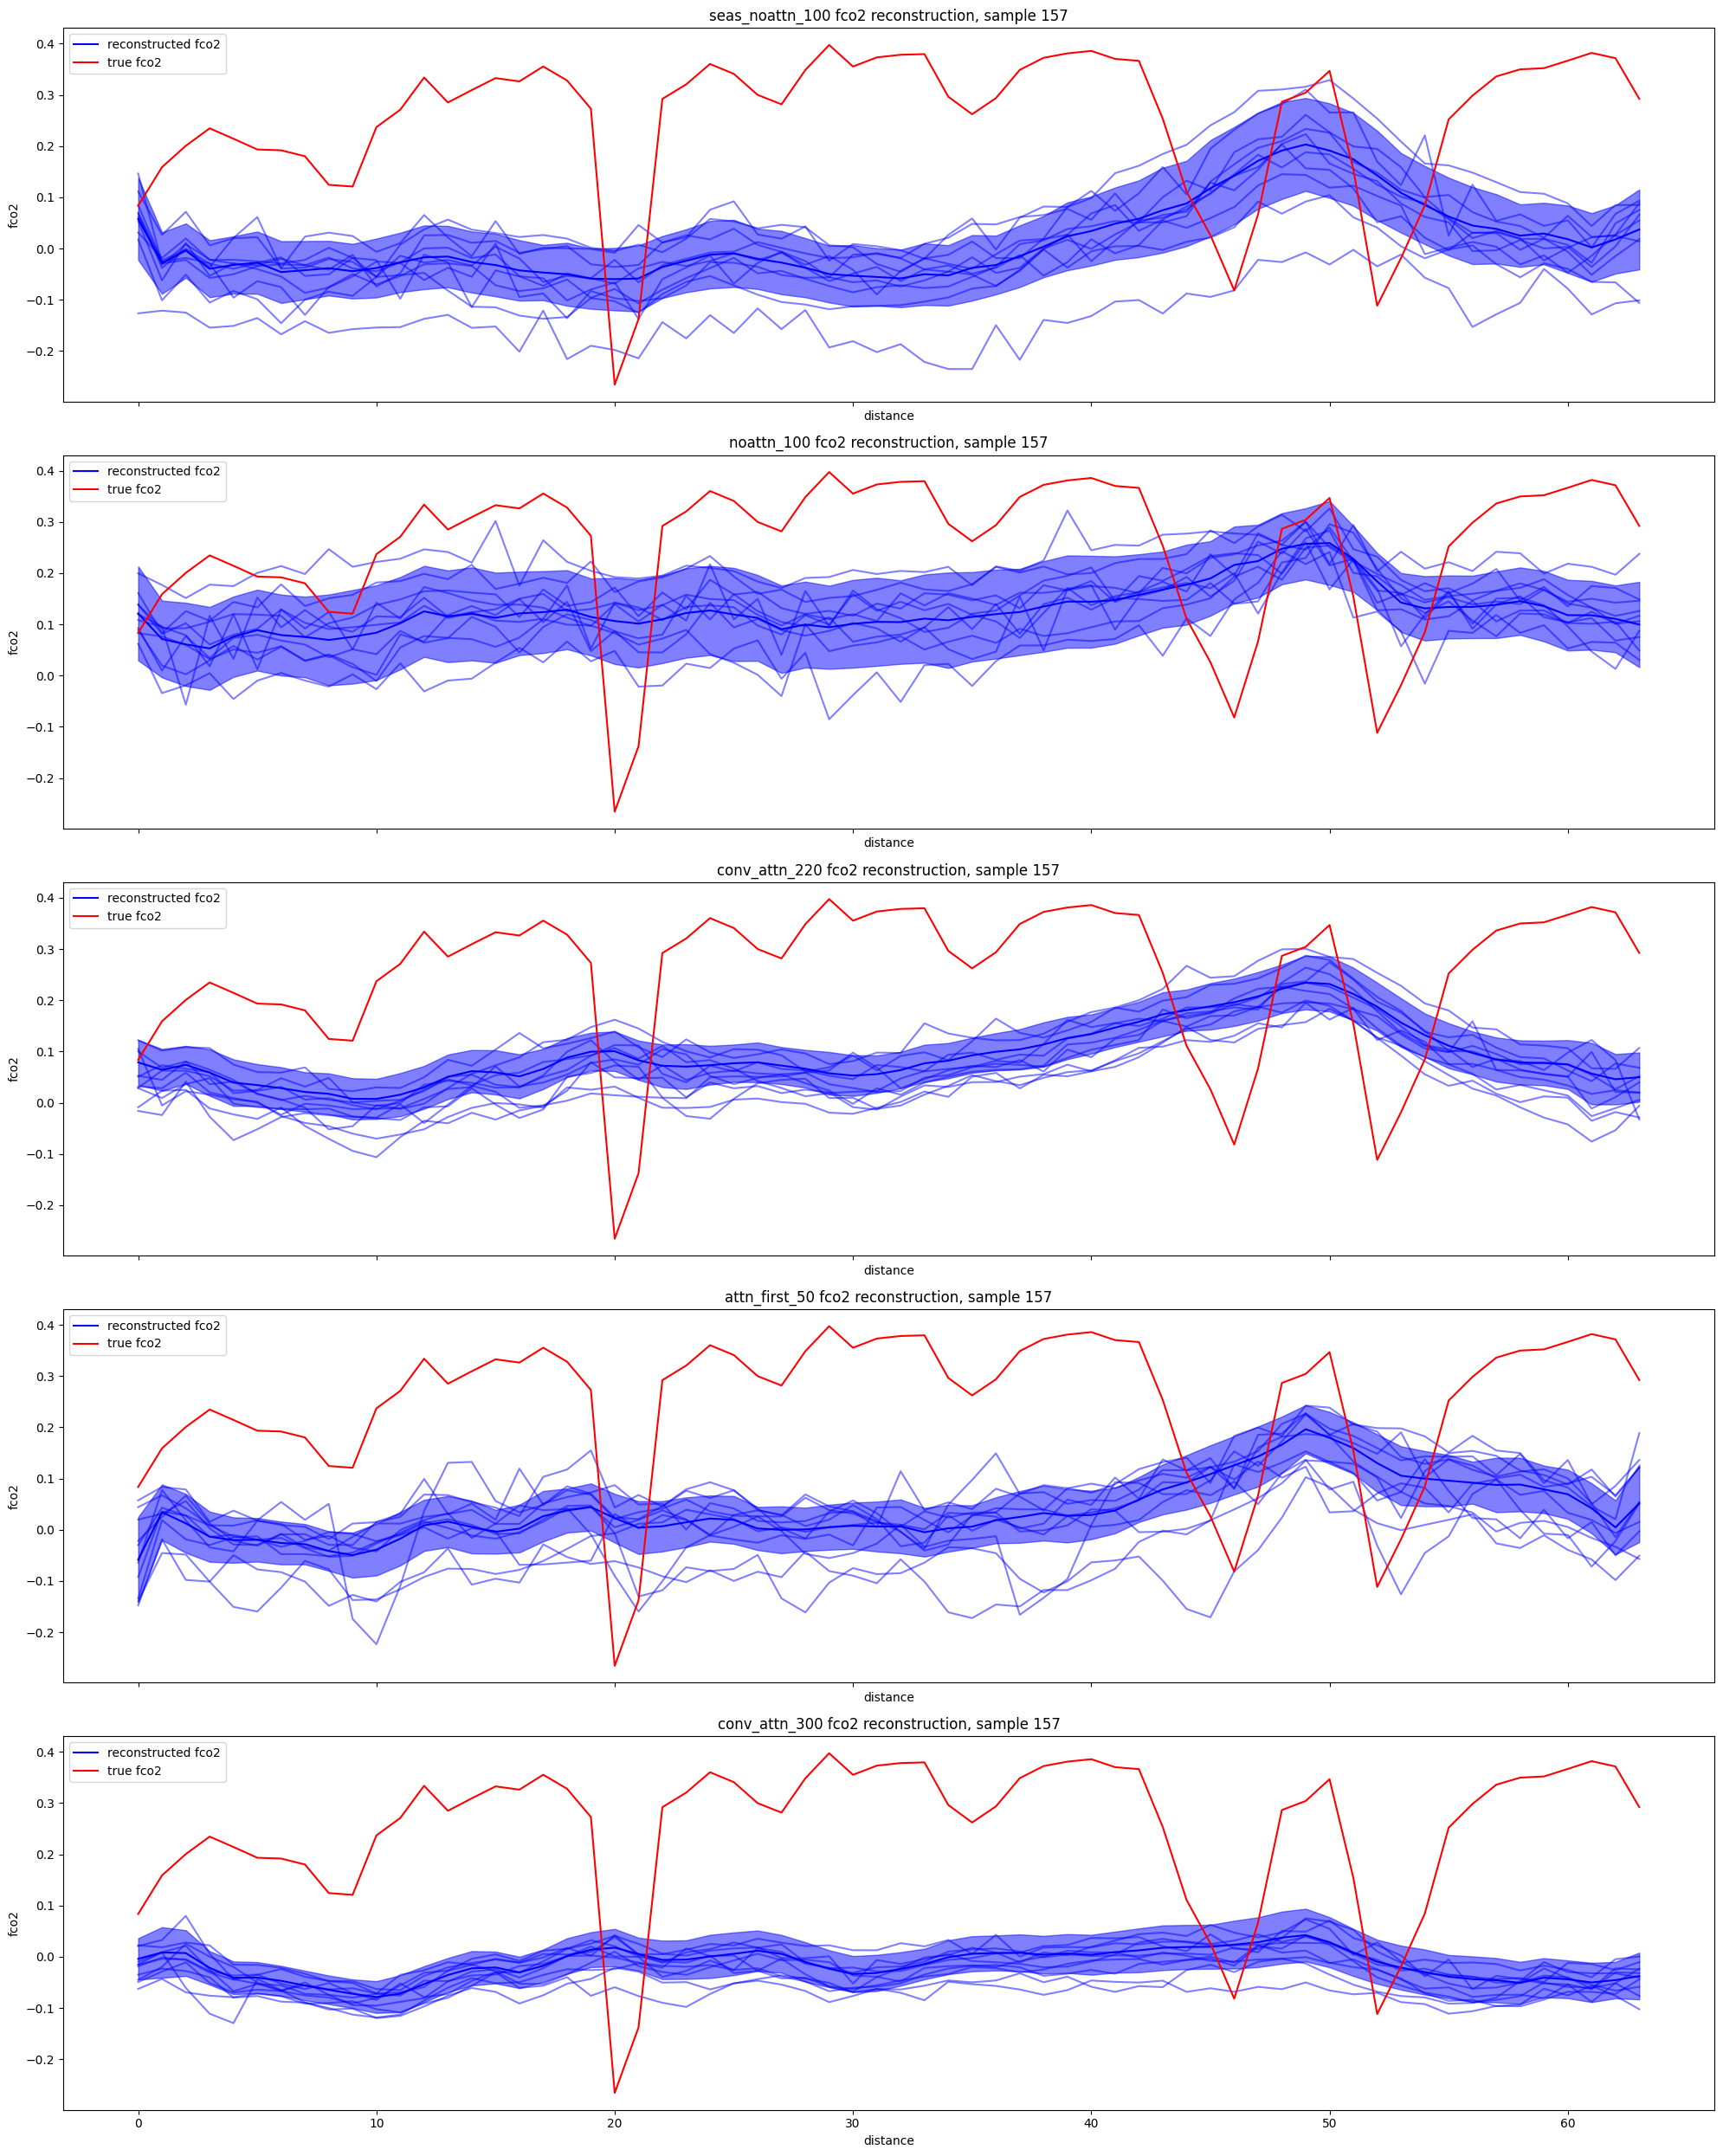

In [5]:
import numpy as np
import matplotlib.pyplot as plt


print(ix)
print(f"mean and std of the sample fco2: {np.nanmean(val_ds[ix, 0:1, :])}, {np.nanstd(val_ds[ix, 0:1, :])}")

sample = val_ds[ix]
timesteps = torch.tensor(900)

recs = dict()
for model_name, model in models.items():
    recs[model_name] = dict()
    recs[model_name]['rec'], recs[model_name]['noisy_samples'] = rec_sample(model['sample'], model['model'], model['scheduler'], timesteps)


# plot the reconstruction
n_models = len(recs.keys())
fig, axs = plt.subplots(n_models, 1, figsize=(20, n_models*5), sharex=True, sharey=True)
for i, (model_name, rec) in enumerate(recs.items()):
    ax = plot_rec(axs[i], rec['rec'], rec['noisy_samples'], sample[0:1], f"{model_name} fco2 reconstruction, sample {ix}", plot_noisy=False)
    ax.legend()
    ax.set_title(f"{model_name} fco2 reconstruction, sample {ix}")
plt.tight_layout()
plt.show()

# Full denoising

In [6]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

def one_full_denoising(truth_context, model, noise_scheduler, n_samples=10, timesteps=900):
    # full denoising loop for a single sample
    # sample = torch.from_numpy(sample_context[0:1, :]).float()
    truth_context = torch.from_numpy(truth_context).float()
    context = truth_context[1:, :]
    # add nan mask to the context
    nan_mask = torch.ones_like(truth_context[0:1, :])
    context = torch.cat([context, nan_mask.float()], dim=0)
    
    sample = torch.randn_like(truth_context[0:1, :]).unsqueeze(0).repeat(n_samples, 1, 1)
    context = context.unsqueeze(0).repeat(n_samples, 1, 1)
    sample_context_ds = TensorDataset(torch.cat([sample, context], dim=1))
    loader = DataLoader(sample_context_ds, batch_size=64, shuffle=False)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    print("model device:", model.device)
    samples = []

    loader = tqdm(loader, desc="Denoising", total=len(loader))

    for batch in loader:
        sample_batch = batch[0][:, 0:1, :].to(device)
        context_batch = batch[0][:, 1:, :].to(device)
        for i, t in enumerate(noise_scheduler.timesteps):
            # concat noise, context
            sample_context_batch = torch.cat([sample_batch, context_batch], dim=1)
            # Get model pred
            with torch.no_grad():
                residual_batch = model(sample_context_batch, t, return_dict=False)[0]
        
            # Update sample with step
            sample_batch = noise_scheduler.step(residual_batch, t, sample_batch).prev_sample.squeeze(0)
            loader.set_postfix({"timestep": t.item()})
        # move to cpu
        # add to samples
        samples.append(sample_batch)

    samples = torch.cat(samples, dim=0)
    samples = samples.cpu().numpy()
    return samples

In [7]:
n_samples = 50
for model_name, model in models.items():
    print(f"denoising {model_name}...")
    recs[model_name]['full_denoising'] = one_full_denoising(model['sample'], model['model'], model['scheduler'], n_samples=n_samples, timesteps=timesteps)

denoising seas_noattn_100...
model device: cuda:0


Denoising: 100%|██████████| 1/1 [00:31<00:00, 31.08s/it, timestep=0]


denoising noattn_100...
model device: cuda:0


Denoising: 100%|██████████| 1/1 [00:23<00:00, 23.08s/it, timestep=0]


denoising conv_attn_220...
model device: cuda:0


Denoising: 100%|██████████| 1/1 [00:35<00:00, 35.57s/it, timestep=0]


denoising attn_first_50...
model device: cuda:0


Denoising: 100%|██████████| 1/1 [01:42<00:00, 102.23s/it, timestep=0]


denoising conv_attn_300...
model device: cuda:0


Denoising: 100%|██████████| 1/1 [00:37<00:00, 37.33s/it, timestep=0]


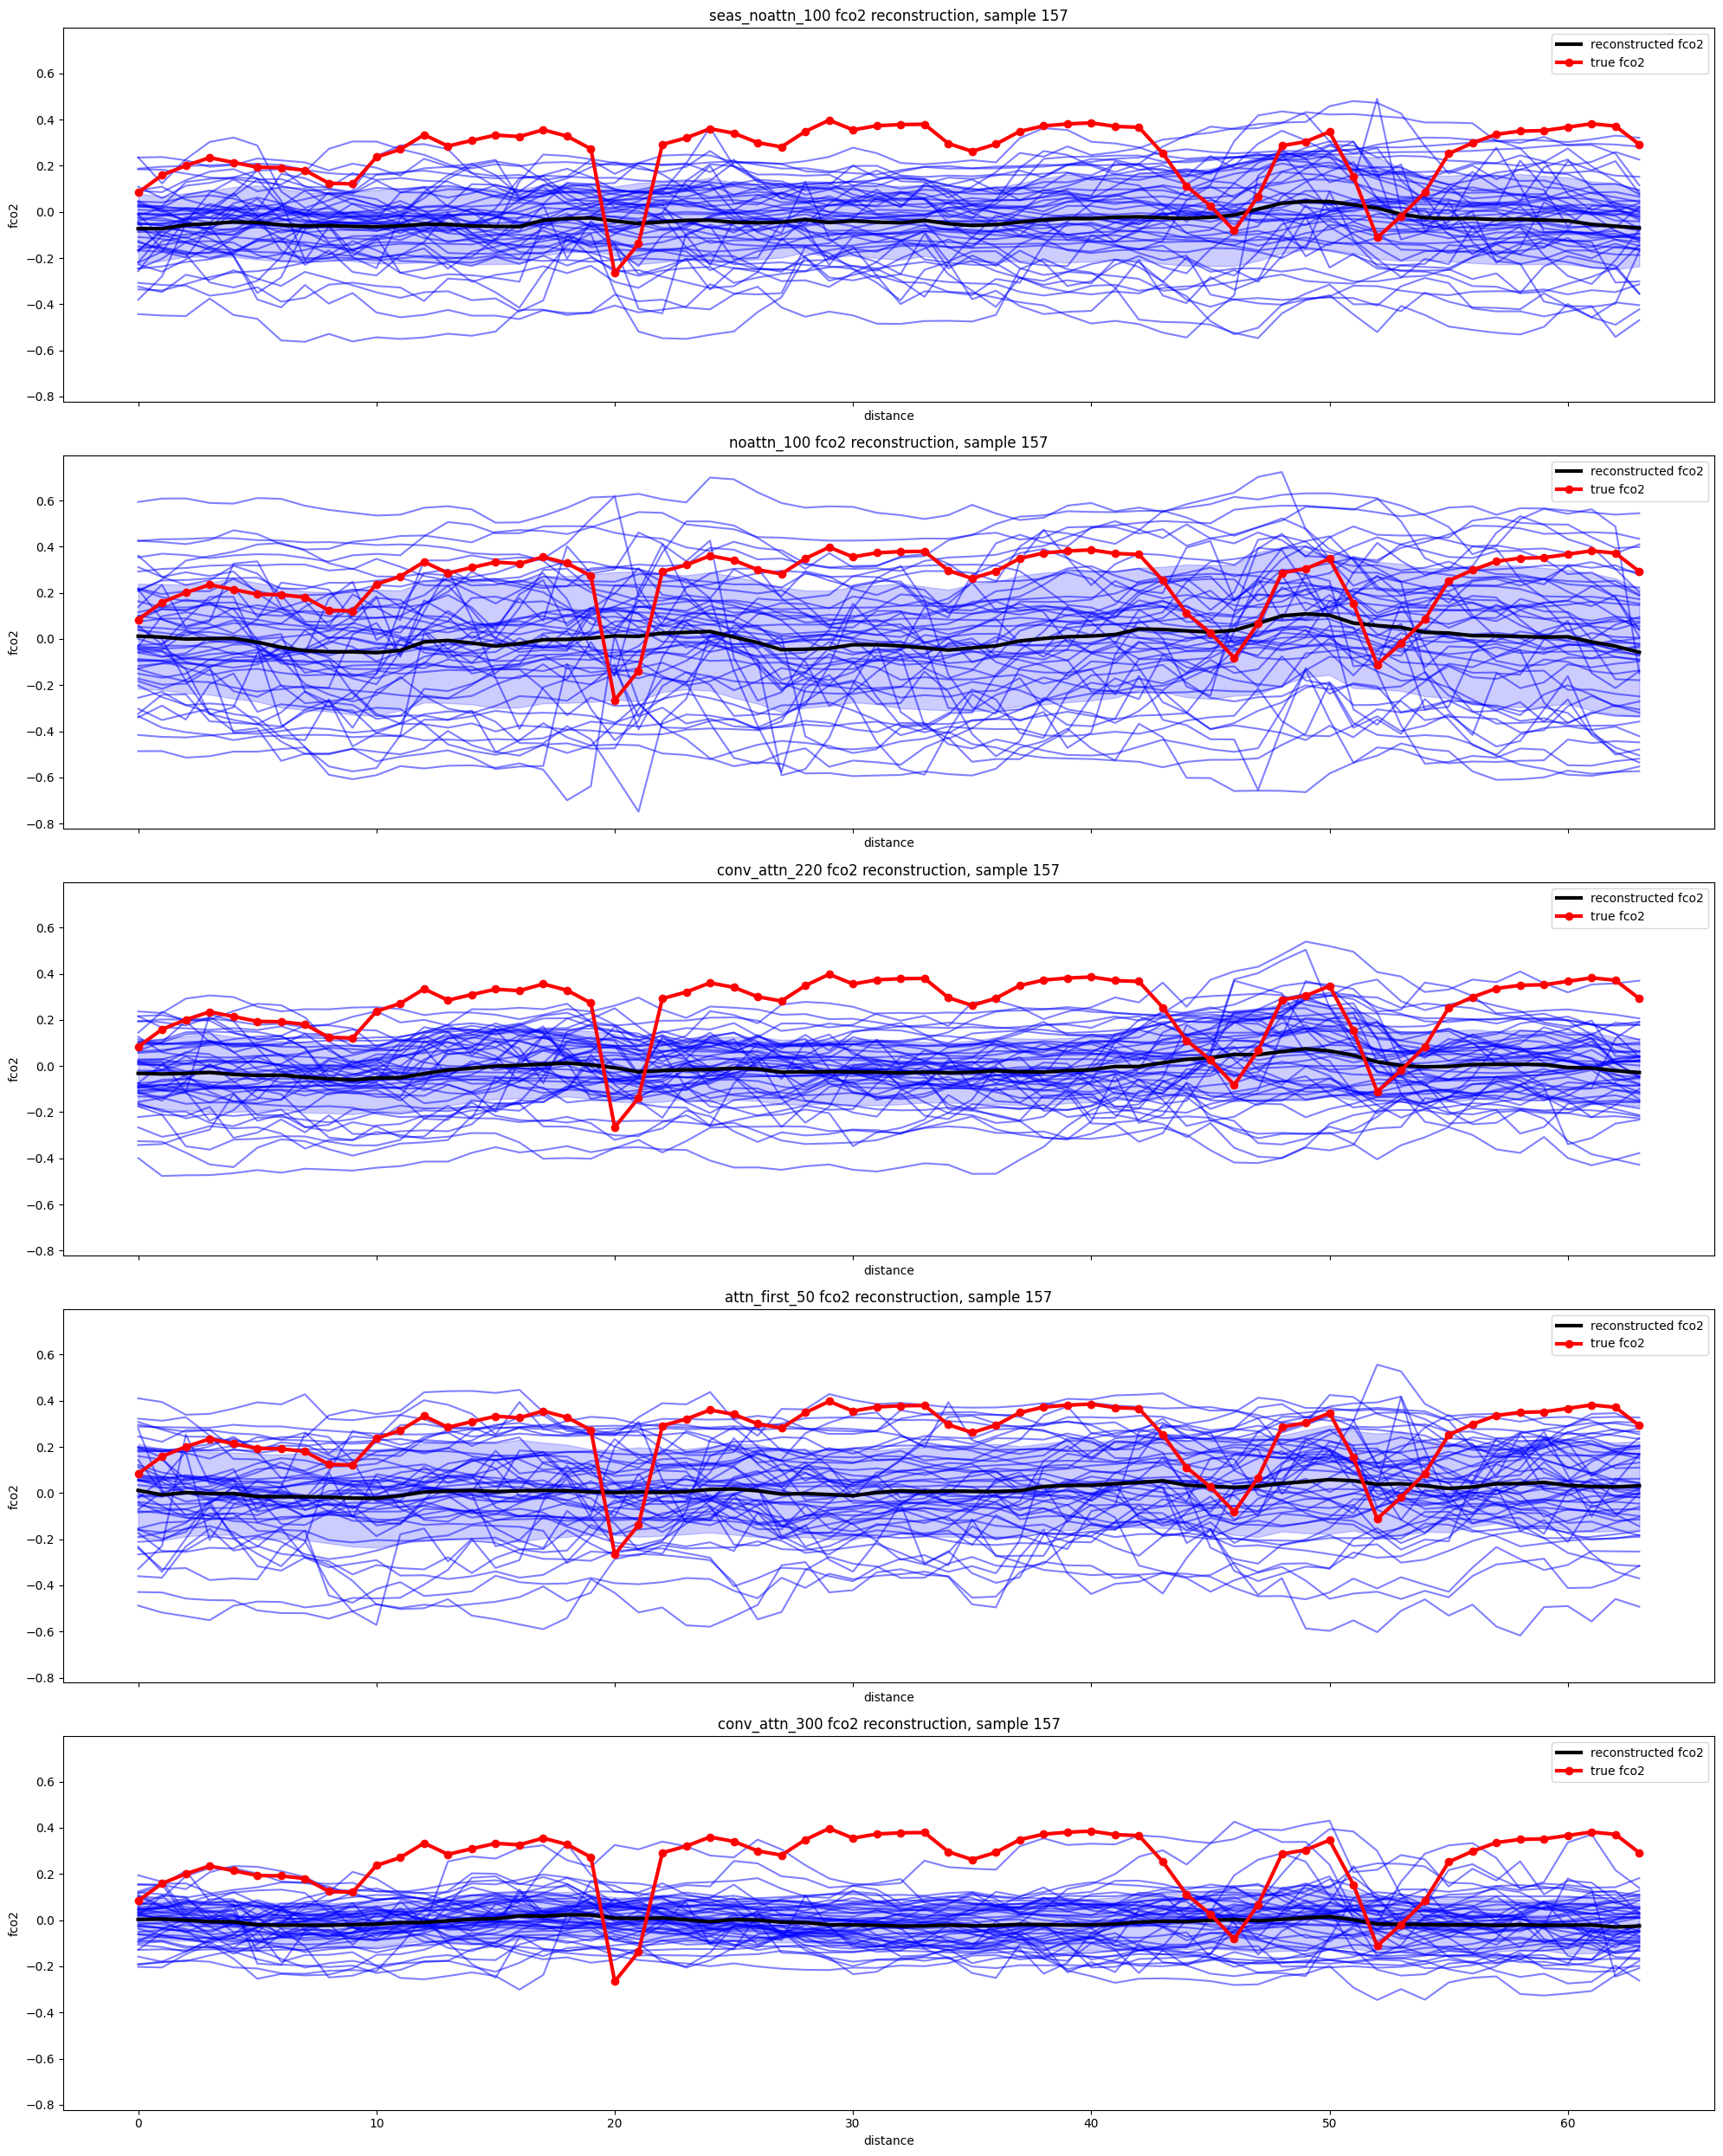

In [8]:
def picp(samples, fco2):
    y_hat_low = np.percentile(samples, 2.5, axis=0)
    y_hat_high = np.percentile(samples, 97.5, axis=0)

    return np.mean((y_hat_low < fco2) * (y_hat_high > fco2)) 

def plot_samples(ax, samples, truth, ix, model):
    ax.plot(samples.T, color='blue', alpha=0.5)
    ax.plot(samples.mean(axis=0), label='reconstructed fco2', color='black', linewidth=3)
    # plot devations from the mean
    ax.fill_between(np.arange(0, 64), samples.mean(axis=0) - samples.std(axis=0),
                     samples.mean(axis=0) + samples.std(axis=0), color='blue', alpha=0.2)
    ax.plot(truth.flatten(), '-o', label='true fco2', color='red', linewidth=3)
    ax.set_title(f"{model} fco2 reconstruction, sample {ix}")
    ax.set_xlabel('distance')
    ax.set_ylabel('fco2')
    ax.legend()
# plot the samples

fig, axs = plt.subplots(n_models, 1, figsize=(20, 5 * n_models), sharex=True, sharey=True)
for i, (model_name, rec) in enumerate(recs.items()):
    plot_samples(axs[i], rec['full_denoising'].squeeze(1), sample[0:1, :], ix, model_name)
    axs[i].legend()
    axs[i].set_title(f"{model_name} fco2 reconstruction, sample {ix}")
    axs[i].set_xlabel('distance')
    axs[i].set_ylabel('fco2')
    axs[i].legend()

plt.tight_layout()

# Jump denoising

In [9]:
# import tensor dataset and loader
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
def one_jump_denoising(truth_context, model, noise_scheduler, n_samples=10, jump=10, timesteps=900):
    # full denoising loop for a single sample
    # sample = torch.from_numpy(sample_context[0:1, :]).float()
    truth_context = torch.from_numpy(truth_context).float()
    context = truth_context[1:, :]
    # add nan mask to the context
    nan_mask = torch.ones_like(truth_context[0:1, :])
    context = torch.cat([context, nan_mask.float()], dim=0)
    
    sample = torch.randn_like(truth_context[0:1, :]).unsqueeze(0).repeat(n_samples, 1, 1)
    context = context.unsqueeze(0).repeat(n_samples, 1, 1)
    sample_context_ds = TensorDataset(torch.cat([sample, context], dim=1))
    loader = DataLoader(sample_context_ds, batch_size=64, shuffle=False)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    print("model device:", model.device)
    samples = []

    loader = tqdm(loader, desc="Denoising", total=len(loader))

    for batch in loader:
        sample_batch = batch[0][:, 0:1, :].to(device)
        context_batch = batch[0][:, 1:, :].to(device)
        for i, t in enumerate(noise_scheduler.timesteps[::jump]):
            # concat noise, context
            sample_context_batch = torch.cat([sample_batch, context_batch], dim=1)
            # Get model pred
            with torch.no_grad():
                residual_batch = model(sample_context_batch, t, return_dict=False)[0]
        
            # Update sample with step
            x_0 = noise_scheduler.step(residual_batch, t, sample_batch).pred_original_sample.squeeze(0)
            if t < jump:
                sample_batch = x_0
            else:
                sample_batch = noise_scheduler.add_noise(x_0, torch.randn_like(sample_batch), t-jump)
            loader.set_postfix({"timestep": t.item()})
        # add to samples
        samples.append(sample_batch)

    samples = torch.cat(samples, dim=0)
    samples = samples.cpu().numpy()
    return samples

In [10]:

fco2 = torch.from_numpy(val_ds[ix, 0:1, :]).float().view(1, 1, -1)
nan_sample = torch.where(torch.isnan(fco2), torch.zeros_like(fco2), fco2)
context = torch.from_numpy(val_ds[ix, 1:, :]).float().view(1, -1, 64)
print(context.shape)
print(sample.shape)

jump = 5
for model_name, model in models.items():
    print(f"denoising {model_name}...")
    recs[model_name]['jump_denoising'] = one_jump_denoising(model['sample'], model['model'], model['scheduler'], n_samples=50, jump=jump, timesteps=timesteps)

torch.Size([1, 4, 64])
(5, 64)
denoising seas_noattn_100...
model device: cuda:0


Denoising: 100%|██████████| 1/1 [00:05<00:00,  5.26s/it, timestep=4]


denoising noattn_100...
model device: cuda:0


Denoising: 100%|██████████| 1/1 [00:05<00:00,  5.75s/it, timestep=4]


denoising conv_attn_220...
model device: cuda:0


Denoising: 100%|██████████| 1/1 [00:07<00:00,  7.83s/it, timestep=4]


denoising attn_first_50...
model device: cuda:0


Denoising: 100%|██████████| 1/1 [00:19<00:00, 19.85s/it, timestep=4]


denoising conv_attn_300...
model device: cuda:0


Denoising: 100%|██████████| 1/1 [00:07<00:00,  7.58s/it, timestep=4]


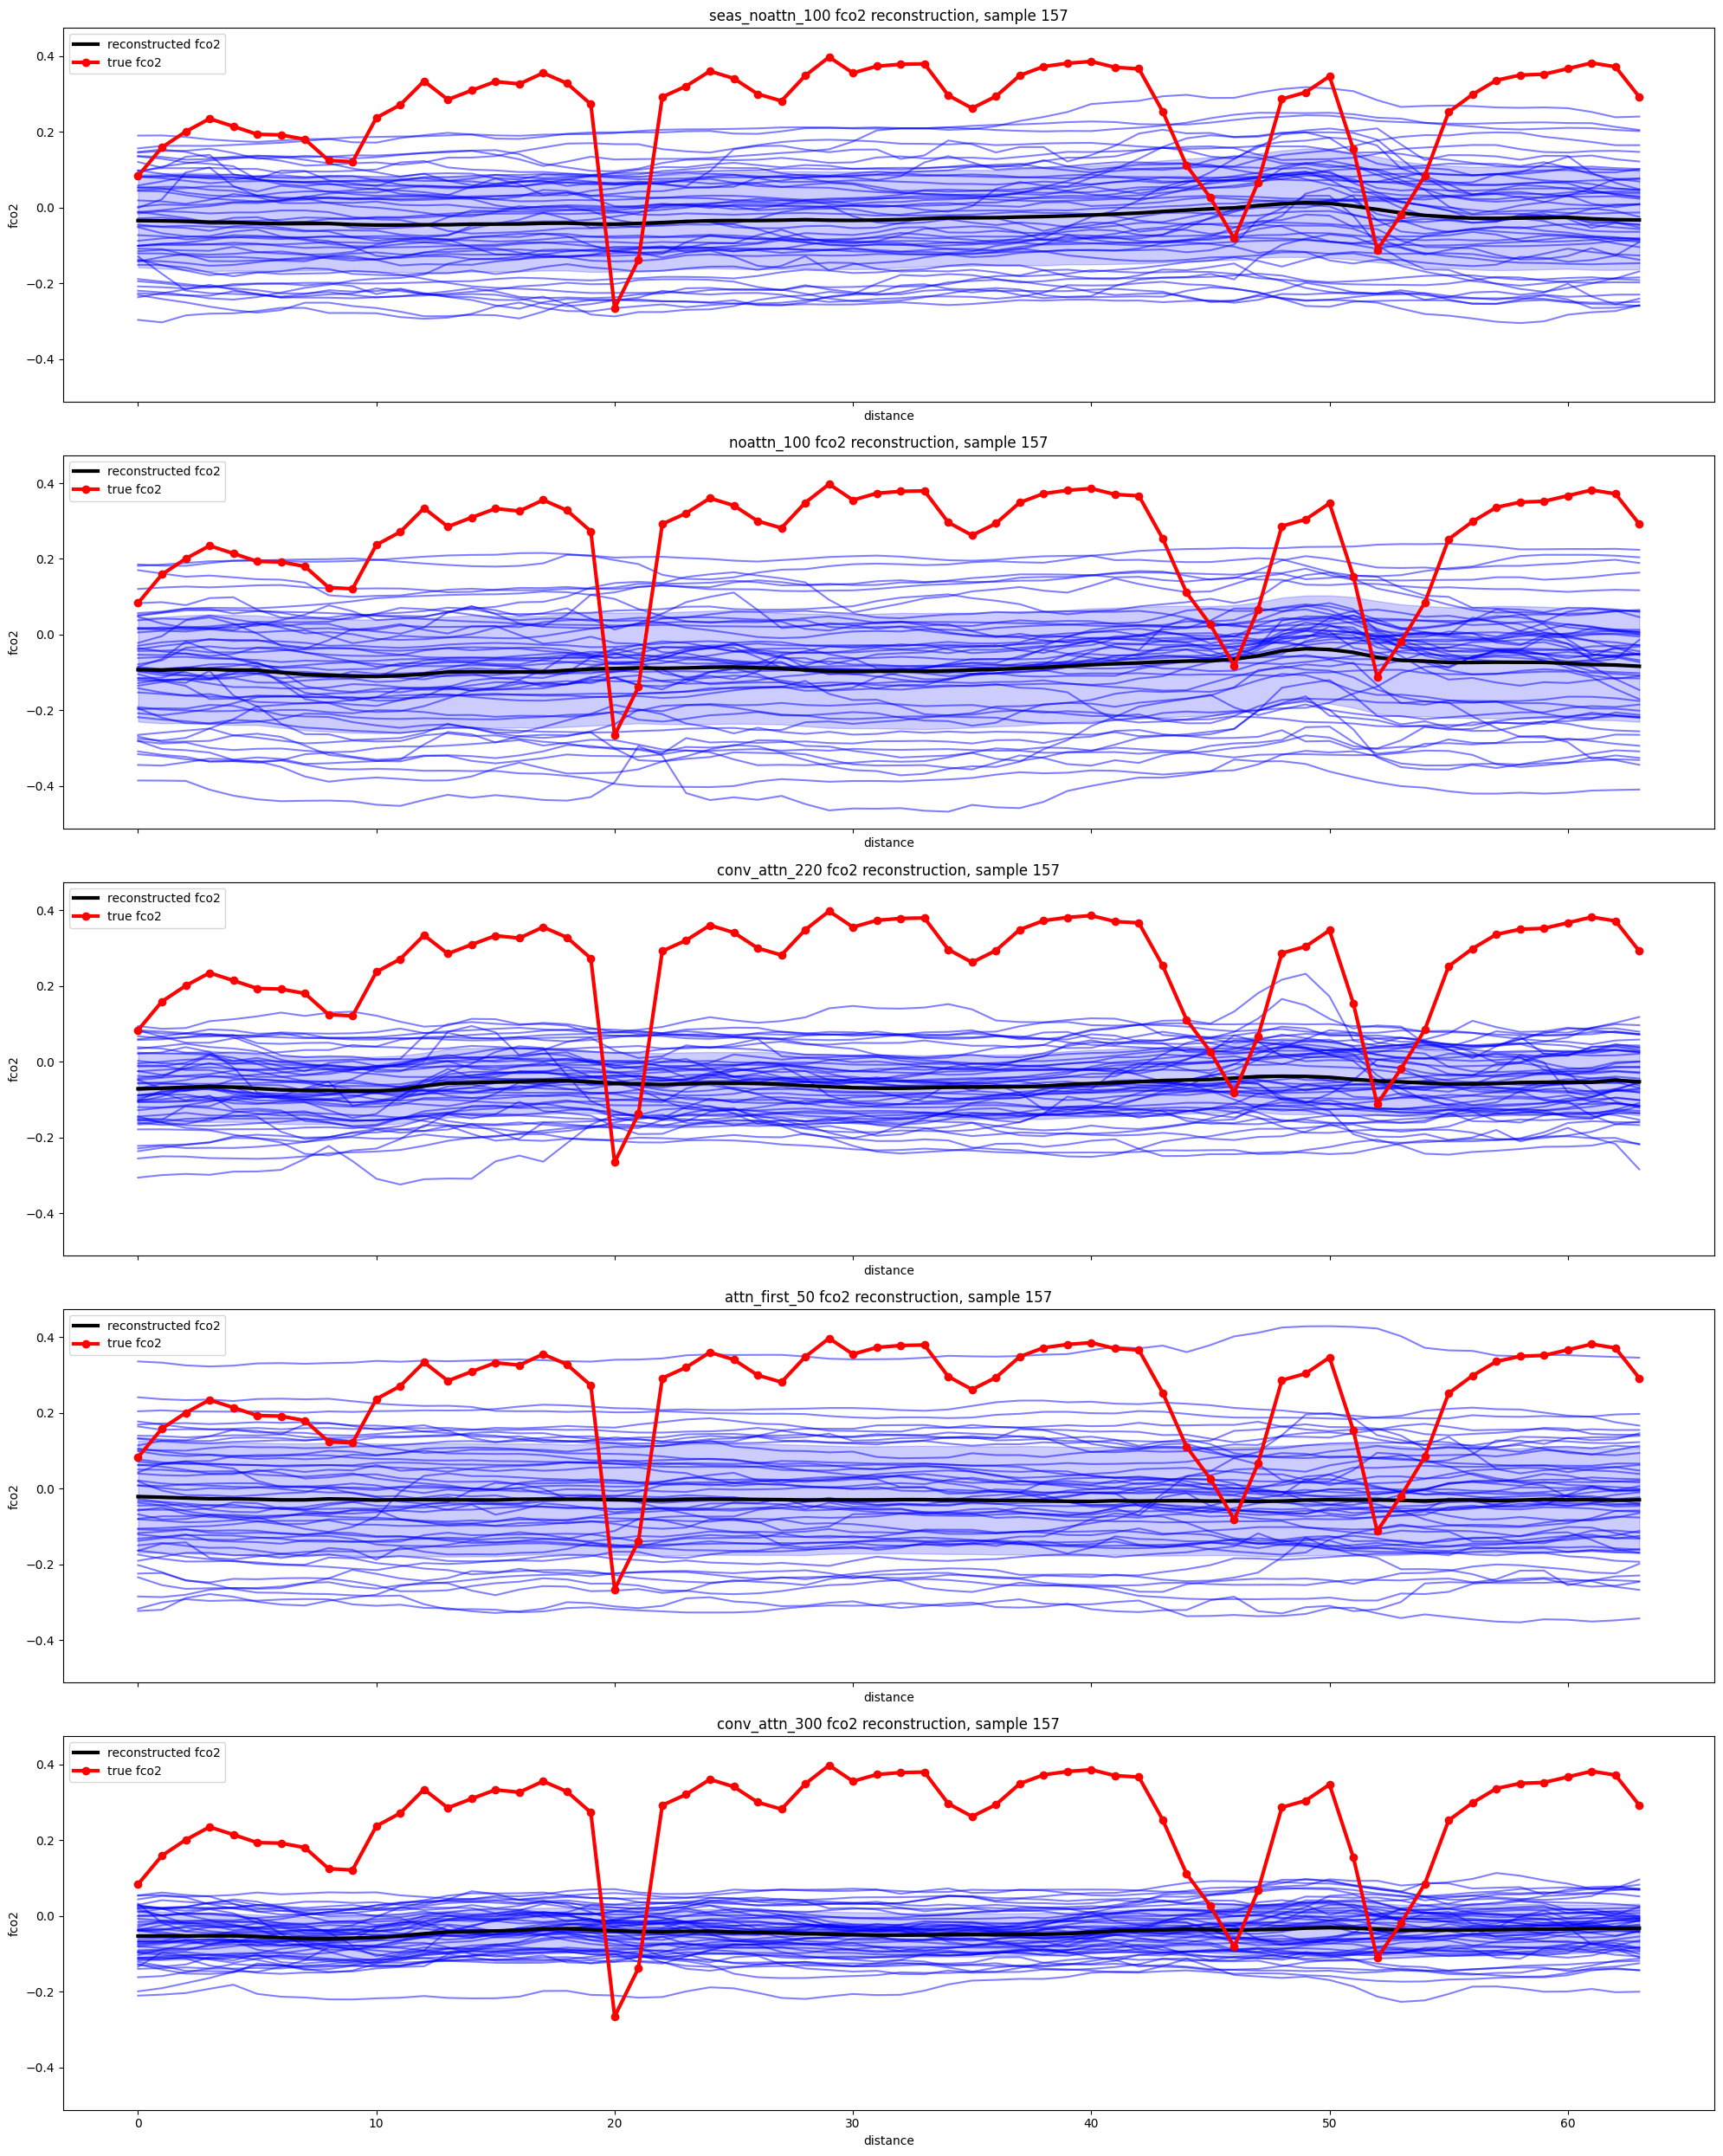

In [11]:
# plot the samples
fig, axs = plt.subplots(n_models, 1, figsize=(20, n_models*5), sharex=True, sharey=True)
# ax = plot_samples(axs[0], samples_1d.squeeze(1), sample[0:1, :], ix, "unet1d")
# ax = plot_samples(axs[1], samples_2d.squeeze(1), sample[0:1, :], ix, "unet2d")
# ax = plot_samples(axs[2], samples_2d_renko.squeeze(1), sample[0:1, :], ix, "unet2d_renko")
# ax = plot_samples(axs[3], samples_2d_renko140.squeeze(1), sample[0:1, :], ix, "unet2d_renko140")
# ax = plot_samples(axs[4], samples_2d_renko190.squeeze(1), sample[0:1, :], ix, "unet2d_renko190")
# plt.tight_layout()
# plt.show()
for i, (model_name, rec) in enumerate(recs.items()):
    plot_samples(axs[i], rec['jump_denoising'].squeeze(1), sample[0:1, :], ix, model_name)
    axs[i].legend()
    axs[i].set_title(f"{model_name} fco2 reconstruction, sample {ix}")
    axs[i].set_xlabel('distance')
    axs[i].set_ylabel('fco2')
    axs[i].legend()
plt.tight_layout()
plt.show()